In [20]:
import numpy as np
import sys 
import matplotlib.pyplot as plt

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

# Baird's Counterexample
Baird's counterexample is described in Section 11.2 of the book. For your convenience, we have implemented it below.

In [2]:
class BairdsCounterExample:                                                                      
    def __init__(self):
        self.n_states = 7
    
    def reset(self):
        self.current = np.random.choice(np.arange(0, 6))
        return self.current 
    
    def step(self, action):
        if action == 1:
            self.current = 6
        elif action == 0:
            self.current = np.random.choice(np.arange(0, 6))
        done = False
        return self.current, 0, done, ""    

# Policies

In [3]:

class TargetPol(object):

    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains a probability
        of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """
        
        probs = []
        for action in actions:
            if action:
                probs.append(1)  
            
            else:
                probs.append(0)  
                
        
        return np.array(probs)
    
    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            state: current state

        Returns:
            An action (int).
        """
        
        actions = list(range(2))
        probs = self.get_probs([state, state], actions)
        # Sample from a categorical distribution
        action = np.argmax(np.random.rand() < probs.cumsum())
        return action
    



class BehaviorPol(object):

    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains a probability
        of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """
        # YOUR CODE HERE
        probs = []
        for action in actions:
            if not action:
                probs.append(6/7)  
            else:
                probs.append(1/6)  

        return np.array(probs)
    
    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            state: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        actions = list(range(2))
        probs = self.get_probs([state, state], actions)
        # Sample from a categorical distribution
        action = np.argmax(np.random.rand() < probs.cumsum())
        return action

## Semi-Gradient TD(0)
Implement Semi-Gradient TD(0) (Equation 11.2 in the book) and plot the values of each weight. Use for your weight vector $w \in \mathbb{R}^8$, with the linear parameterization as given in Figure 11.1 of the book. Use a step size of $\alpha=0.01$, a discount factor of $\gamma=0.99$ and initialize the weights as $w=(1, 1, 1, 1, 1, 1, 10, 1)$ and run for 1000 steps.

In [67]:
def semi_gradient_td(env, behavior_policy, target_policy, num_steps, alpha=0.01, discount_factor=0.99):
    """
    Semi-gradien TD(0) algorithm: Finds the optimal state-value function using a behavior policy to select 
    actions while learning about a target policy.
    
    Args:
        env: Environment class object.
        policy: A behavior policy which allows us to sample actions.
        num_steps: Number of update steps to run for.
        alpha: Update step-size.
        discount_factor: Gamma discount factor.
    
    """
    # initialize weights
    
    w = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 1.0])
    V = np.zeros((num_steps+1, len(w)))
    X = np.array([[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                  [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                  [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                  [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0],
                  [0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0]])
    
    state = env.reset()
    V[0] = w
    
    for i in range(num_steps):        
        action = behavior_policy.sample_action(state)
        next_state, reward, done, _ = env.step(action)
        
        behavior_prob = behavior_policy.get_probs([state], [action])[0]
        target_prob = target_policy.get_probs([state], [action])[0]
        importance_sampling_ratio = target_prob / behavior_prob
        # print(importance_sampling_ratio)
                
        # semigradient off-policy TD update
        w += alpha * importance_sampling_ratio*(reward + discount_factor * w @ X[next_state] - w @ X[state])*X[state]
        # print(w)
        state = next_state
        V[i+1]=w
    
        # print(V)
 
    
    return w, V

# now plot the values of each weight over the 1000 update steps
w, V =semi_gradient_td(BairdsCounterExample(), BehaviorPol(), TargetPol(), num_steps=1000, alpha=0.01, discount_factor=0.99)


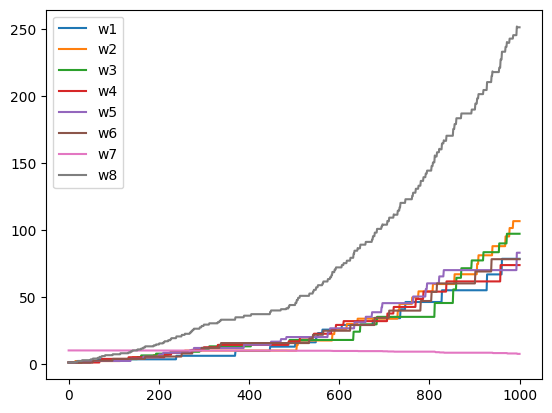

In [68]:
fig = plt.figure()

for i in range(8):
    plt.plot(list(range(1001)), V[:,i], label=f"w{i+1}")

plt.legend()
plt.show()

We can see how the weights explote and therefore we have divergence. The true value function should be 0, i.e, w should be 0